In [1]:
%matplotlib inline

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as si

In [3]:
import adolc

In [4]:
# from clawpack.geoclaw import dtopotools
adapt_utils_home = os.environ.get('ADAPT_UTILS_HOME')
sys.path.append(os.path.join(adapt_utils_home, 'unsteady', 'swe', 'tsunami'))
import dtopotools

As in the previous notebook, we generate a source comprised of an array of Okada functions, using the work of [Shao et al. 2012].

A $19\times10$ array of subfaults is used, each of which is assumed to be based on a rectangular patch with length $25\,\mathrm{km}$ and width $20\,\mathrm{km}$.
For the Okada function associated with each of the $190$ subfaults, there are nine control parameters:

  1. latitude;
  2. longitude;
  3. depth;
  4. slip;
  5. rake;
  6. strike;
  7. dip;
  8. length;
  9. width.

Each Okada function returns an $N\times N$ array of values, where $N$ is to be specified by the user and can be thought of as grid resolution for the topography field.
The contribution of each is summed in order to generate the total topography.

In summary, `okada` can be thought of as a function with $190\times9=1,710$ scalar inputs and $N^2$ scalar outputs.

In this notebook, we apply the Python wrapper `pyadolc` to the C++ operator overloading automatic differentiation tool `ADOL-C`.
`ADOL-C` works by overloading common functions with known derivatives using C++ templates.
An enriched version of the `double` type is provided: the `adouble`.
The main difference is that `adouble`s are able to propagate derivatives as well as their 'standard' values.
Operations on `adouble`s are recorded on a tape so that the workflow can be read at a later time and both forward and reverse mode derivatives may be automatically generated.

From experience, I can say that applying `ADOL-C` to an existing C or C++ code is not always completely straightforward (at least for the non-expert user), since extra memory needs to be allocated for `adouble`s due to their enriched storage.
In Python, memory handling is not typically something the user needs to worry about and so the process becomes somewhat simpler.

Suppose we have a function $f=f(x)$ and its Python implementation `f`.
If the piece of code we would like to differentiate looks like

    y = f(x)
    
then the `pyadolc` differentiated version looks like

    adolc.trace_on(tag)
    x_a = adolc.adouble(x)
    adolc.independent(x_a)
    y_a = f(x_a)
    adolc.dependent(y_a)
    adolc.trace_off()

where `tag` is simply a label for the tape being used.
Evaluating (for example) the gradient of $f$ at a point $x_0$ then becomes as simple as calling the appropriate driver:

    dfdx = adolc.gradient(tag, x0)
    
where $x0$ encodes the point $x_0$.

`pyadolc` supports `numpy` expressions such as `sin`, `cos`, `exp`.

In [5]:
# Get data (assuming that the Okada parameters have already been downloaded)
di = os.path.join(adapt_utils_home, 'case_studies', 'tohoku', 'resources', 'surf')
with open(os.path.join(di, 'okada_parameters.txt')) as f:
    data_str = f.read()

# Set up a dictionary of lists
controls = ('latitude', 'longitude', 'depth', 'slip', 'rake', 'strike', 'dip')
source_parameters = {}
for control in controls:
    source_parameters[control] = []
source_parameters['length'] = []
source_parameters['width'] = []

# Populate the dictionary
for i, line in enumerate(data_str.split('\n')):
    if i < 12:
        continue
    for word, control in zip(line.split(), controls):
        val = float(word)
        if control == 'slip':
            val /= 100  # convert from cm to m
        if control == 'depth':
            val *= 1000  # convert from km to m
        source_parameters[control].append(val)
    if line not in ('', '\n'):
        source_parameters['length'].append(25.0e+03)
        source_parameters['width'].append(20.0e+03)

In [6]:
mean_source_parameters = {  # source is based on a 19x10 grid
    'length': 19*source_parameters['length'][0],
    'width': 10*source_parameters['width'][0],
}
for control in controls:
    mean_source_parameters[control] = np.mean(source_parameters[control])
    print("mean {:10s}:  {:.2f}".format(control, mean_source_parameters[control]))
print("total length   :  {:.2f}".format(mean_source_parameters['length']))
print("total width    :  {:.2f}".format(mean_source_parameters['width']))

mean latitude  :  37.91
mean longitude :  142.66
mean depth     :  24736.48
mean slip      :  12.54
mean rake      :  67.18
mean strike    :  198.00
mean dip       :  10.00
total length   :  475000.00
total width    :  200000.00


Create a uniform grid upon which to evaluate Okada function

In [7]:
N = 101
x = np.linspace(138, 148, N)
y = np.linspace(32, 42, N)

Function to create a fault from Okada control parameters GeoCLAW's `Fault` and `Subfault` classes.

In [8]:
num_subfaults = len(source_parameters['latitude'])
for var in source_parameters:
    assert len(source_parameters[var]) == num_subfaults

# Create subfaults and fault
subfaults = [dtopotools.SubFault() for i in range(num_subfaults)]
for subfault in subfaults:
    subfault.coordinate_specification = 'centroid'
fault = dtopotools.Fault(x, y, subfaults=subfaults)

tag = 0
adolc.trace_on(tag)  # >>>>> trace on >>>>>

l = 5
msg = "subfault {:3d}: shear modulus {:.4e} Pa, seismic moment is {:.4e}"
for i in range(num_subfaults):
    
    # Read parameters as adoubles
    subfaults[i].latitude = adolc.adouble(source_parameters['latitude'][i])
    subfaults[i].longitude = adolc.adouble(source_parameters['longitude'][i])
    subfaults[i].depth = adolc.adouble(source_parameters['depth'][i])
    subfaults[i].slip = adolc.adouble(source_parameters['slip'][i])
    subfaults[i].rake = adolc.adouble(source_parameters['rake'][i])
    subfaults[i].strike = adolc.adouble(source_parameters['strike'][i])
    subfaults[i].dip = adolc.adouble(source_parameters['dip'][i])
    subfaults[i].length = adolc.adouble(source_parameters['length'][i])
    subfaults[i].width = adolc.adouble(source_parameters['width'][i])
    
    # Mark as independent
    adolc.independent(subfaults[i].latitude)
    adolc.independent(subfaults[i].longitude)
    adolc.independent(subfaults[i].depth)
    adolc.independent(subfaults[i].slip)
    adolc.independent(subfaults[i].rake)
    adolc.independent(subfaults[i].strike)
    adolc.independent(subfaults[i].dip)
    adolc.independent(subfaults[i].length)
    adolc.independent(subfaults[i].width)
    
    # Printing
    if i < l or i > num_subfaults - l - 1:
        print(msg.format(i, subfaults[i].mu, subfaults[i].Mo().val))
    elif i == l:
        print("...")
print("this corresponds to an earthquake with moment magnitude {:.1f}".format(fault.Mw().val))

# Create the topography, thereby calling Okada
print("\nCreating topography...")
fault.create_dtopography()
print("Done!")

# Mark output as dependent
adolc.dependent(fault.dtopo.dZ_a)

adolc.trace_off()  # <<<<< trace off <<<<<

subfault   0: shear modulus 4.0000e+10 Pa, seismic moment is 2.0897e+17
subfault   1: shear modulus 4.0000e+10 Pa, seismic moment is 6.3714e+19
subfault   2: shear modulus 4.0000e+10 Pa, seismic moment is 1.1783e+20
subfault   3: shear modulus 4.0000e+10 Pa, seismic moment is 2.5073e+20
subfault   4: shear modulus 4.0000e+10 Pa, seismic moment is 3.9883e+20
...
subfault 185: shear modulus 4.0000e+10 Pa, seismic moment is 5.8755e+19
subfault 186: shear modulus 4.0000e+10 Pa, seismic moment is 5.4531e+19
subfault 187: shear modulus 4.0000e+10 Pa, seismic moment is 5.9979e+19
subfault 188: shear modulus 4.0000e+10 Pa, seismic moment is 4.9508e+19
subfault 189: shear modulus 4.0000e+10 Pa, seismic moment is 4.9258e+19
this corresponds to an earthquake with moment magnitude 9.1

Creating topography...
created topography for subfault 1/190 (10.6 seconds)
created topography for subfault 11/190 (99.1 seconds)
created topography for subfault 21/190 (100.8 seconds)
created topography for subfaul

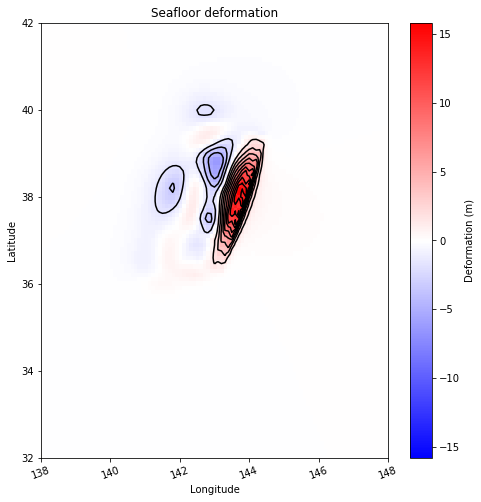

In [9]:
fig, axes = plt.subplots(figsize=(8, 8))
fault.dtopo.plot_dZ_colors(t=1.0, axes=axes);
axes.set_xlabel('Longitude');
axes.set_ylabel('Latitude');

In [10]:
X = []
for i in range(num_subfaults):
    
    # Read parameters as adoubles
    X.append(source_parameters['latitude'][i])
    X.append(source_parameters['longitude'][i])
    X.append(source_parameters['depth'][i])
    X.append(source_parameters['slip'][i])
    X.append(source_parameters['rake'][i])
    X.append(source_parameters['strike'][i])
    X.append(source_parameters['dip'][i])
    X.append(source_parameters['length'][i])
    X.append(source_parameters['width'][i])
    
X = np.array(X)

In [11]:
# seed = np.zeros(X.shape)
# seed[0] = 1
# F, dFdX = adolc.fos_forward(tag, X, seed, 0)

In [12]:
seeds = np.array([[1 if i % 9 == j else 0 for j in range(9)] for i in range(len(X))])

In [13]:
F, dFdX = adolc.fov_forward(tag, X, seeds)

In [14]:
dFdX.shape

(10201, 9)

In [15]:
controls = ('latitude', 'longitude', 'depth', 'slip', 'rake', 'strike', 'dip', 'length', 'width', )

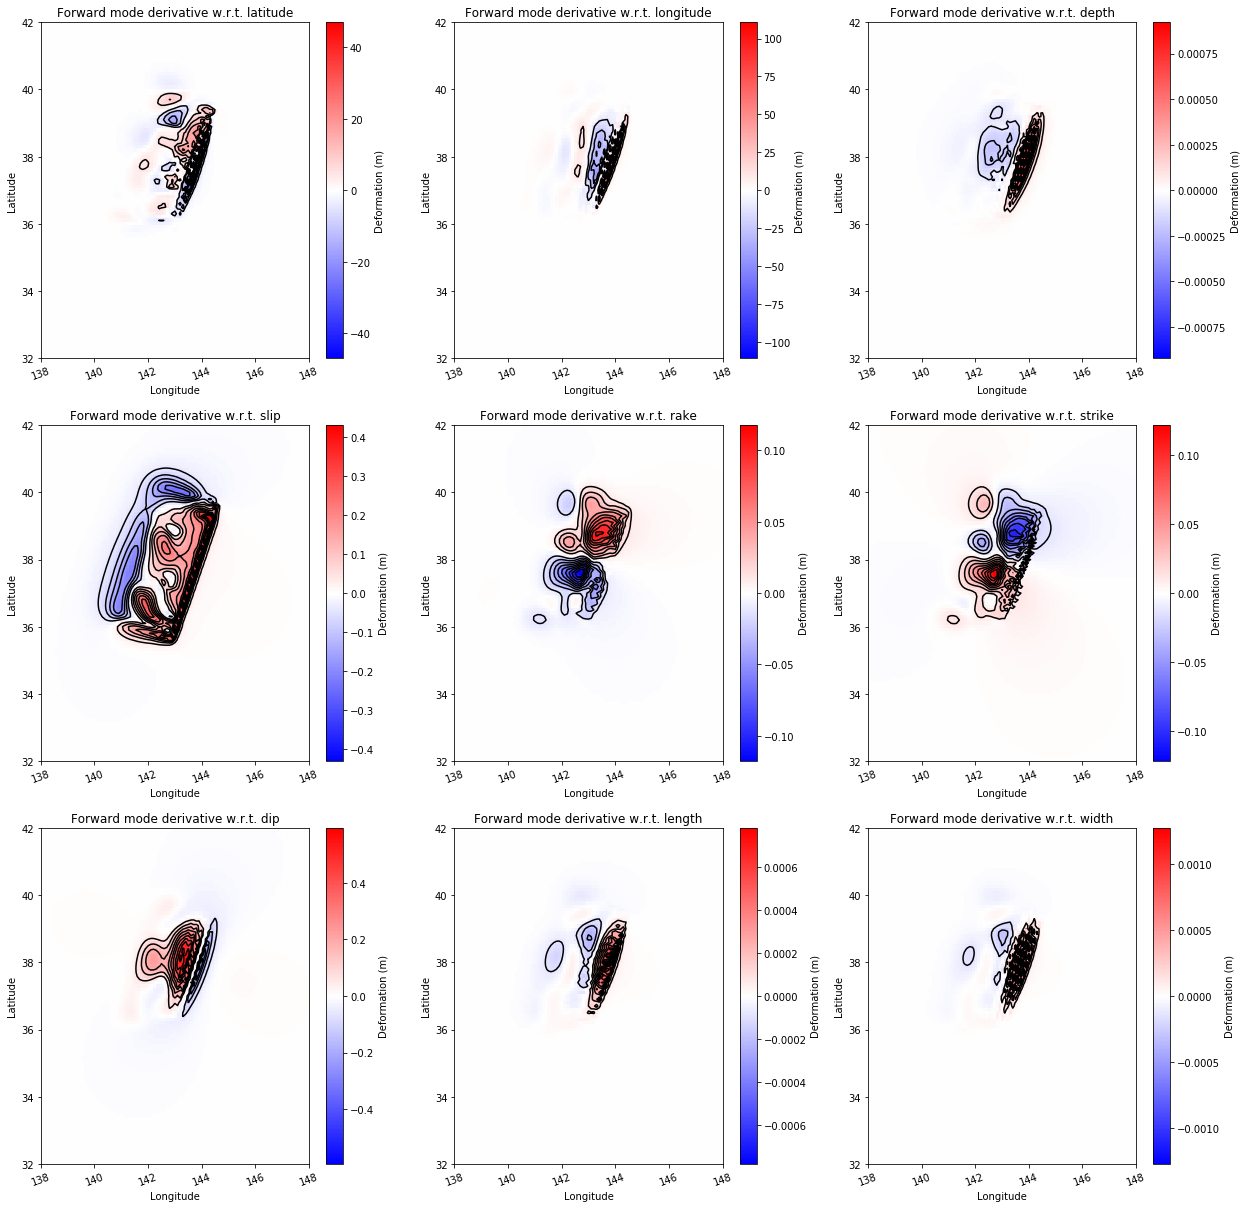

In [16]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(21, 21))

for i, control in enumerate(controls):
    ax = axes[i // 3, i % 3]
    fault.dtopo.dZ = dFdX[:, i].reshape(1, N, N)
    fault.dtopo.plot_dZ_colors(t=1.0, axes=ax);
    ax.set_xlabel('Longitude');
    ax.set_ylabel('Latitude');
    ax.set_title('Forward mode derivative w.r.t. {:s}'.format(control));

# TODO: Remove colorbar label

# TODO: Reverse mode approach